In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [4]:
path = '../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv'
print(path)

../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv


In [5]:
def import_files(path):
    struc = pd.DataFrame(columns =["radiation_level", "path","code_file","group"])
    read = os.walk(path)
    for root, dirs, files in read:
        for name in files:
            if name.endswith(".csv"):
                #print(name)
                radiation = name.split("gy")
                [_,group,_] = name.split("_") 
                filepath = path+ '/' + name
                code_file = name[:-4] #removing suffix
                
                struc = struc.append({"radiation_level" : int(radiation[0]), "path" : filepath, "code_file" : code_file, "group" : group}, ignore_index=True)
                
    return struc

In [6]:
def str_to_numpy(input_str):
    """
    str_to_numpy is used to parse the columns "input" and "output" of the dataset csv files.
    It converts a string representing an array of cells to a numpy array containing strings
    which are the names of these cells.
    """
    process_str = input_str.replace("[", "")
    process_str = process_str.replace("'", "")
    process_str = process_str.replace(" ", "")
    process_str = process_str.replace("]", "")
    if(process_str != ""):
        process_str = process_str.split(",")
        output_array = np.asarray(process_str, dtype=str)
    else:
        output_array = np.asarray([], dtype=str)
    return output_array

In [7]:
file = path + "/0gy_n1_201104.nd2u2510Gy1A.csv"
data = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy}) #imports a dataframe from a csv 
                  # and converts its string components to numpy
data.head()


,time,event,input,output
0,0,begin,[],[C1]
1,66,div,[C1],"[C1.1, C1.2]"
2,238,div,[C1.1],"[C1.1.1, C1.1.2]"
3,386,div,[C1.1.1],"[C1.1.1.1, C1.1.1.2]"
4,432,end,[C1.1.1.1],[]


## Algorithm :

We suppose that trees do not merge.

1. List begin events -> give us the root cells for each tree
2. Group together cells which contains the name of previous cells ("C1" and "C1.1" e.g.)
   1. Create a DataFrame with [root_cell, cell_name, time, event, input, ouput]

In [8]:
roots = data.loc[data.event == 'begin'].output
roots.head()

0     [C1]
16    [C2]
23    [C3]
39    [C4]
49    [C5]
Name: output, dtype: object

In [22]:
def root_cell_test(row, root): #Tests if the row corresponds to the root cell
    for c in row.input:
        if str(c).startswith(root):
            return True

    return False

def obtain_roots(experience):
    roots = experience.loc[experience.event == 'begin'].output 
    root_cells = []
    for cell in roots:
        root_cells.append(str(cell[0]))
    print(root_cells)
    return(root_cells)

def cells_to_trees(experience): #experience is a DataFrame
    #Select root cells in experience
    root_cells = obtain_roots(experience) 

    #Creation of a tree corresponding to the experience
    trees = pd.DataFrame(columns = ["root_cell", "time","event","input","output"])
    frames = []
    for root in root_cells:
        #exp_bis = experience.loc[experience.event != "begin"]
        f = lambda row:root_cell_test(row, str(root))
        root_cell = experience[experience.apply(f, axis=1)]
        root_cell.insert(loc=0, column='root_cell', value=root, allow_duplicates=True)
        #trees = trees.append(root_cell)
        root_cell=root_cell.sort_values(by='time')
        trees = pd.concat([trees, root_cell], ignore_index=True, sort=False)
    return trees

In [23]:
#TEST 2
experience = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy})
trees = cells_to_trees(experience)
trees[trees.event == "death"]

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


,root_cell,time,event,input,output
106,C8,293,death,[C8.3],[]


['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


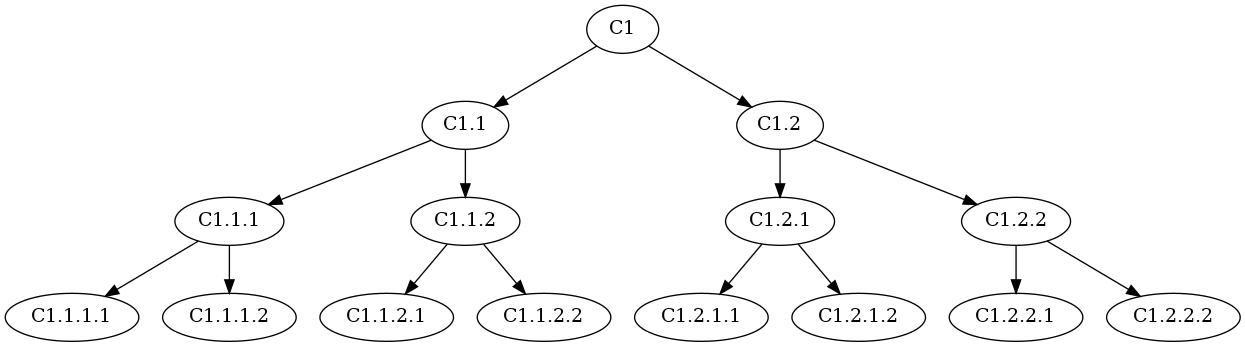

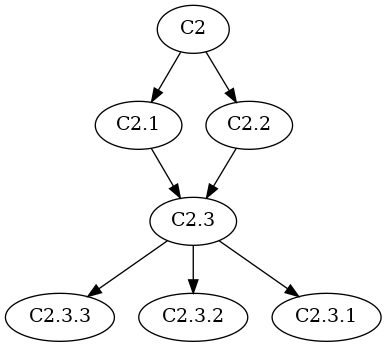

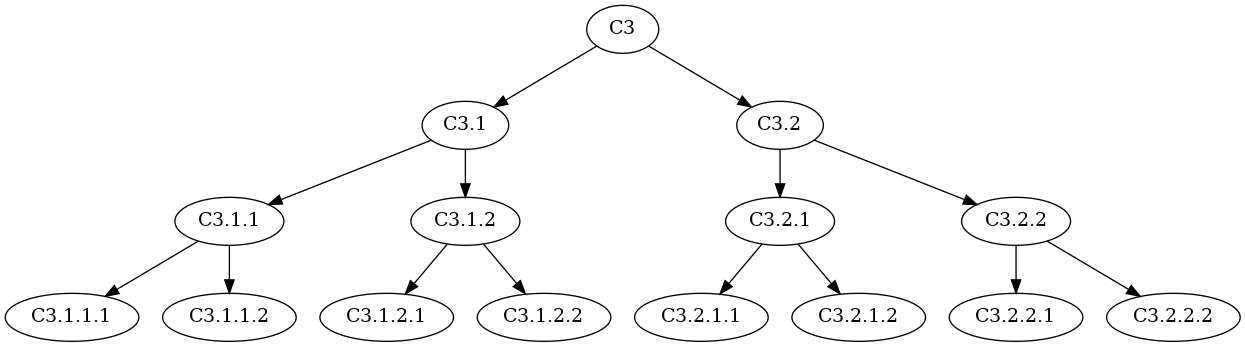

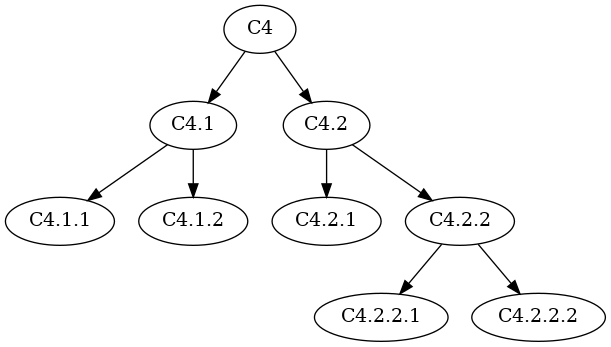

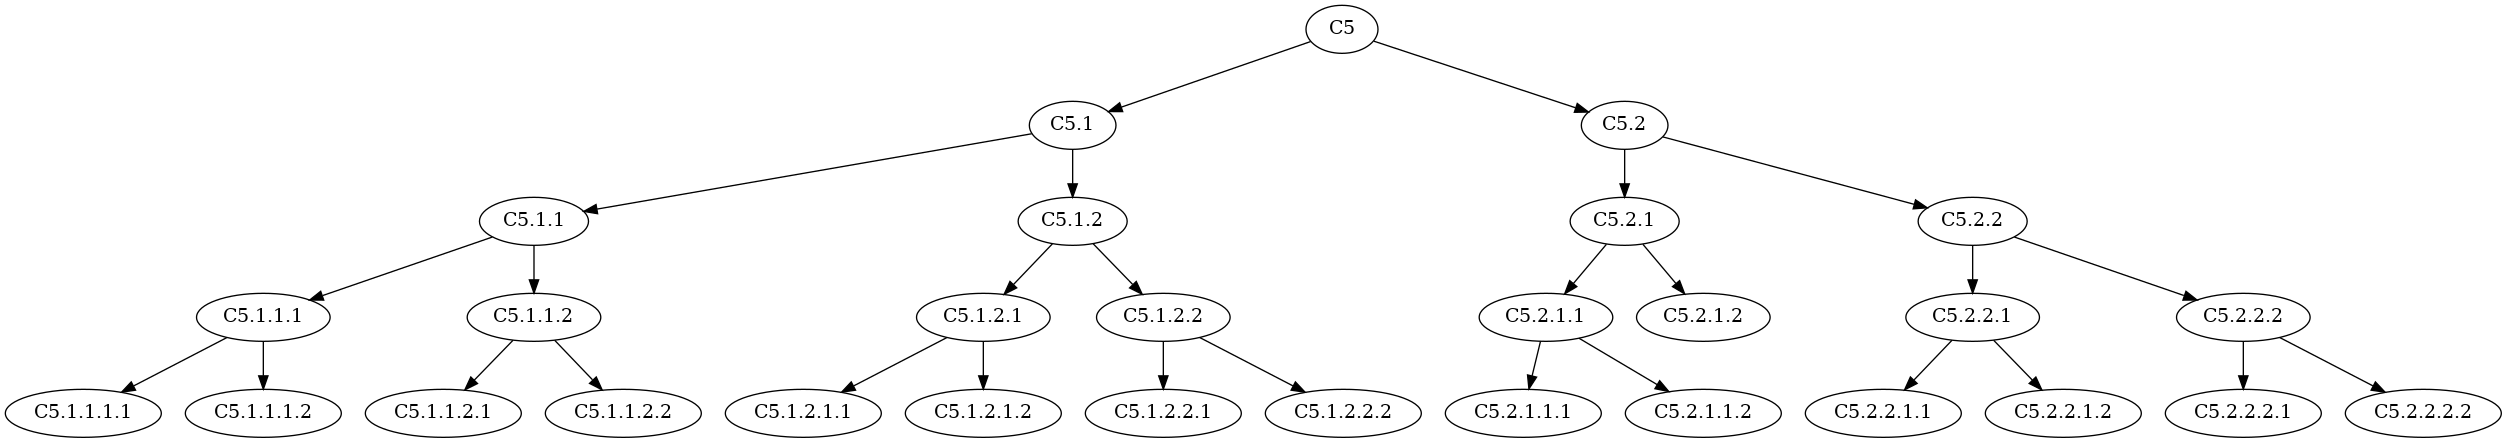

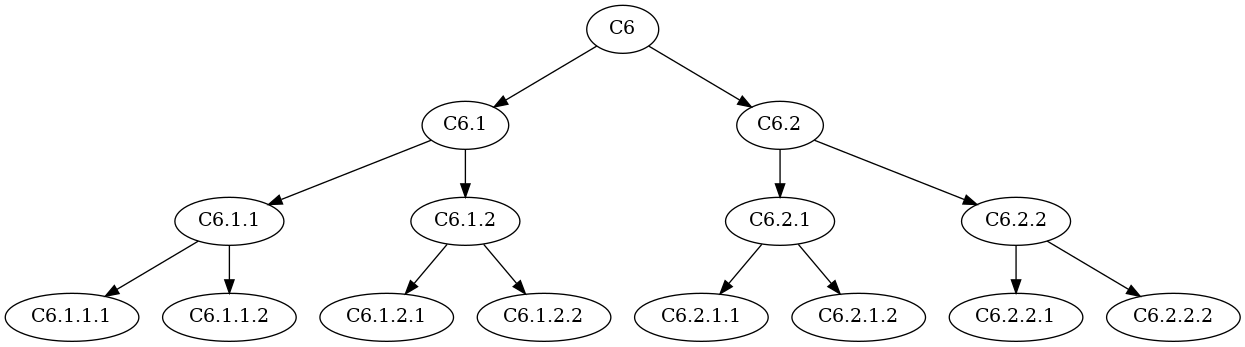

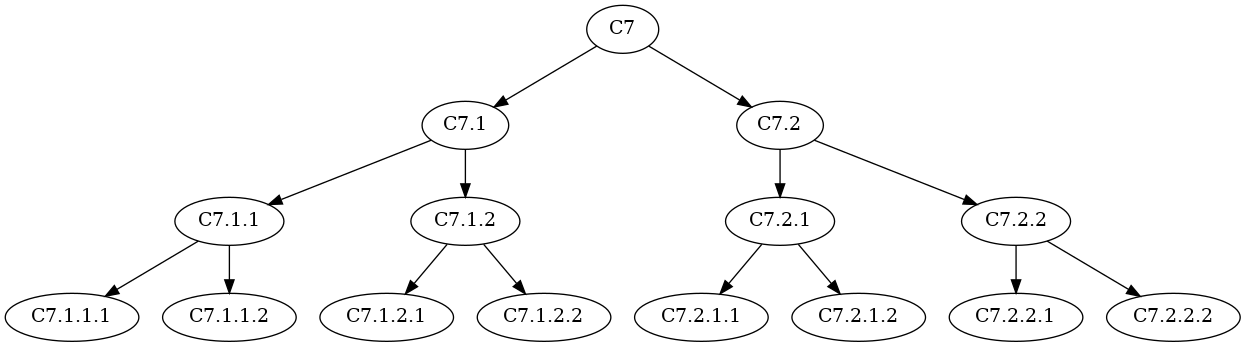

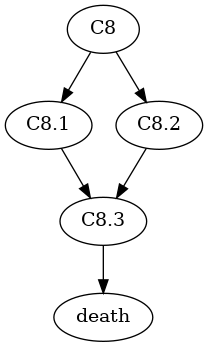

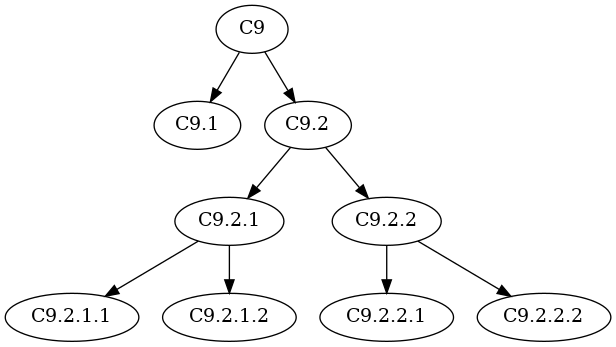

In [27]:
import pygraphviz as pgv
from IPython.display import Image, display

size_factor = 50;

def draw(dot):
    return display(Image(pgv.AGraph(dot).draw(format='png', prog='dot')))
    # return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato'))) # with distance : not currently functionnal

def event_to_str(row, cell):
    dot_txt = cell + " [ pos = \"0,0!\" ]"
    if row.root_cell == cell:
        cell 
        for c_i in row.input:
            for c_o in row.output:
                dot_txt += c_o.replace(".", "") + " [ label = \"" +c_o+ "\", pos = \"0,"+str(-row.time/size_factor)+"!\"] \n"
                dot_txt +=  c_i.replace(".", "") + " -> " + c_o.replace(".", "") + "\n"
        if row.event == "death" :
            dot_txt += row.input[0].replace(".", "") + " -> death \n"
        # if row.event == "end" :
        #     str += row.input[0].replace(".", "") + " -> alive \n" # Don't give a great looking result.
                
    return dot_txt

graphs = []
for c in obtain_roots(experience) :
    g = lambda row : event_to_str(row, c)

    t = trees.apply(g, axis=1)
    graph = "digraph top {"
    for row in t:
        if row!="" :
            graph += row
    graph += "}"
    graphs.append(graph)

for graph in graphs:
    draw(graph)

In [47]:
tree1 = trees[trees["root_cell"] == "C1"]
t1 = trees.groupby(["root_cell"])
t1.describe()
t1.apply(event_to_str)

['C1']
['C1.1']
['C1.2']
['C1.2.1']
['C1.1.1']
['C1.1.2']
['C1.2.2']
['C1.1.1.1']
['C1.1.1.2']
['C1.1.2.1']
['C1.1.2.2']
['C1.2.1.1']
['C1.2.1.2']
['C1.2.2.1']
['C1.2.2.2']
['C2']
['C2.1' 'C2.2']
['C2.3']
['C2.3.3']
['C2.3.2']
['C2.3.1']
['C3']
['C3.1']
['C3.2']
['C3.2.2']
['C3.2.1']
['C3.1.2']
['C3.1.1']
['C3.1.1.1']
['C3.1.1.2']
['C3.1.2.1']
['C3.1.2.2']
['C3.2.1.1']
['C3.2.1.2']
['C3.2.2.1']
['C3.2.2.2']
['C4']
['C4.2']
['C4.1']
['C4.2.2']
['C4.1.1']
['C4.1.2']
['C4.2.1']
['C4.2.2.1']
['C4.2.2.2']
['C5']
['C5.2']
['C5.1']
['C5.2.2']
['C5.2.1']
['C5.1.1']
['C5.1.2']
['C5.2.2.2']
['C5.2.1.1']
['C5.2.2.1']
['C5.1.2.2']
['C5.1.1.2']
['C5.1.2.1']
['C5.1.1.1']
['C5.2.2.1.2']
['C5.2.2.1.1']
['C5.2.1.1.2']
['C5.2.1.1.1']
['C5.1.2.2.1']
['C5.1.2.2.2']
['C5.2.2.2.1']
['C5.1.2.1.2']
['C5.1.2.1.1']
['C5.1.1.2.2']
['C5.1.1.2.1']
['C5.1.1.1.2']
['C5.1.1.1.1']
['C5.2.1.2']
['C5.2.2.2.2']
['C6']
['C6.1']
['C6.2']
['C6.1.1']
['C6.1.2']
['C6.2.1']
['C6.2.2']
['C6.1.1.1']
['C6.1.1.2']
['C6.1.2.1']
['C

""


In [12]:
def list_of_trees(data_frame):
    trees_list = pd.DataFrame(columns =["tree_id", "tree"])
    for idx in data_frame.index:

        #Select experience correspondingto index idx
        path = data_frame.loc[idx,'path']
        file_name = data_frame.loc[idx,'code_file']
        file_path = path + "/"+ file_name + ".csv"
        experience = pd.read_csv(file_path, converters = {"input" : str_to_numpy, "output" : str_to_numpy})

        trees = cells_to_trees(experience)
        
        #Add experience trees to the list of all trees
        trees_list.append({"tree_id" : "pouet"})